# Assignment 1 - Track 6

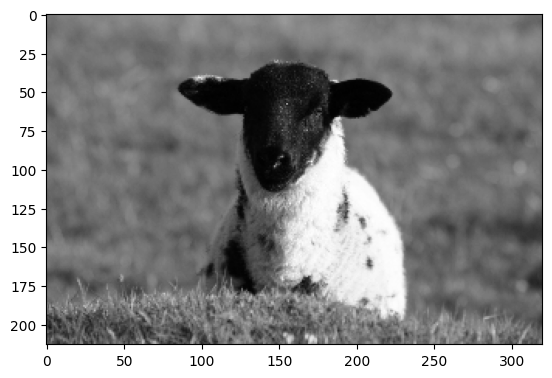

In [42]:
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
import cv2

# Path: main.ipynb

img = cv2.imread('./images/1_27_s.bmp', cv2.IMREAD_GRAYSCALE)

# display image
plt.imshow(img, cmap='gray')
plt.show()

### Defining convolution function and LoG generator

Log defined as:
$$ \nabla^2G(x,y) = -\frac{1}{\pi\sigma^4} \left[1 - \frac{x^2+y^2}{2\sigma^2}\right] \exp \left\{ -\frac{x^2+y^2}{2\sigma^2}\right\} $$

Convolution function defined as:
$$ C(x,y) = \sum_{i=0}^{k} \sum_{j=0}^{k} I(x+i,y+j)K(i,j) $$
where $I$ is the image, $K$ is the kernel and $k = dim(K)$

Image has been padded with zeros to avoid boundary issues.

In [2]:
def convolve(img, kernel) -> np.ndarray:

    h, w = img.shape
    kh, kw = kernel.shape
    conv = np.zeros((h, w))

    # some padding
    img = np.pad(img, (kh//2, kw//2), 'constant')

    # separate function for numba
    @numba.jit(nopython=True)
    def process(img, h, w, kh, kw, conv):
        # iterate over image
        for x in range(h):
            for y in range(w):
                # of course using compact numpy notation instead of explicit loops for sum
                conv[x, y] = (kernel * img[x: x+kh, y: y+kw]).sum()
        return conv

    return process(img, h, w, kh, kw, conv)

@numba.jit(nopython=True)
def log(i, j, sigma):
    return (-1)/(np.pi * sigma**4) * (1 - (i**2 + j**2)/(2*sigma**2)) * np.exp(-(i**2+j**2)/(2*sigma**2))

@numba.jit(nopython=True)
def laplacian_of_gaussian(dim, sigma=1, k=1):
    kernel = np.zeros((dim, dim)) 
    for i in range(-dim//2, dim//2+1):
        for j in range(-dim//2, dim//2+1):
            kernel[i+dim//2, j+dim//2] = log(i, j, sigma)

    # normalize kernel
    return sigma**2 * kernel

## First try: test kernel generation and convolution implementation

### Kernel plot

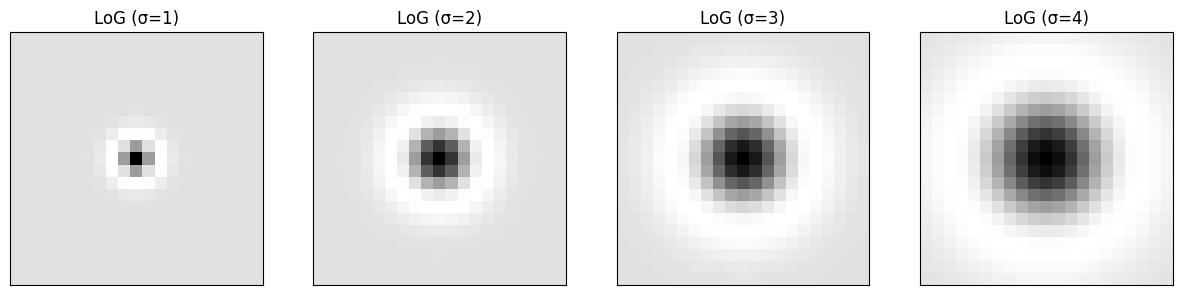

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, sigma in enumerate([1, 2, 3, 4]):
    kernel = laplacian_of_gaussian(21, sigma)
    axs[i].imshow(kernel, cmap='gray')
    axs[i].set_title(f'LoG (σ={sigma})')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Generated kernels actually are LoGs. This pictures also suggest how in the next part larger kernels will be needed to exploit higher sigma values and to provide a good local LoG approximation.

 Now, test convolution on the normalized image, with sigma = 2 and kernel size = 21

### Convolution test

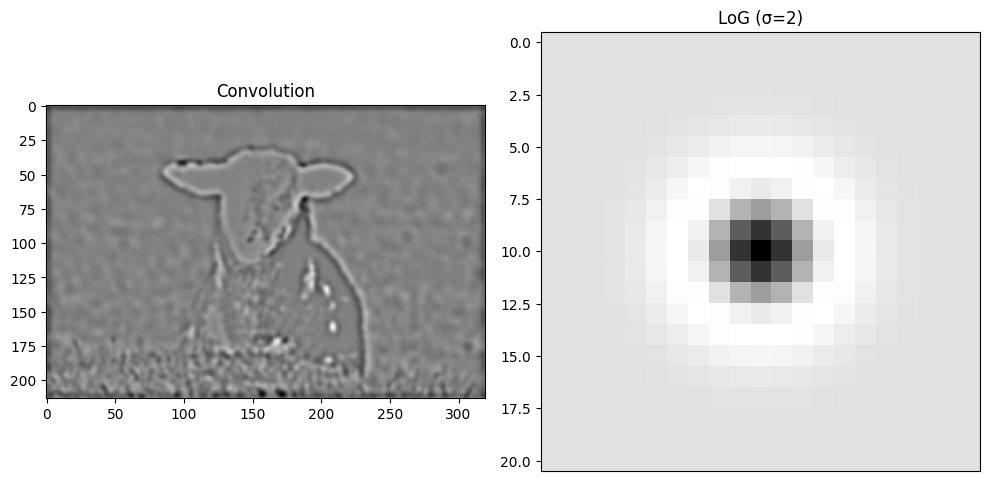

In [4]:
kernel = laplacian_of_gaussian(21, 2)
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# normalizing image to [0, 1]
axs[0].imshow(convolve(img/255, kernel), cmap='gray')

axs[0].set_title('Convolution')
axs[1].imshow(kernel, cmap='gray')
axs[1].set_title('LoG (σ=2)')
axs[1].set_xticks([])
fig.tight_layout()

It works as expected, since LoG is basically an edge detector.

### Comparison of my convolution with openCV.filter2D. 
 Note: openCV.filter2D actually computes correlation, not convolution.

Text(0.5, 1.0, 'OpenCV')

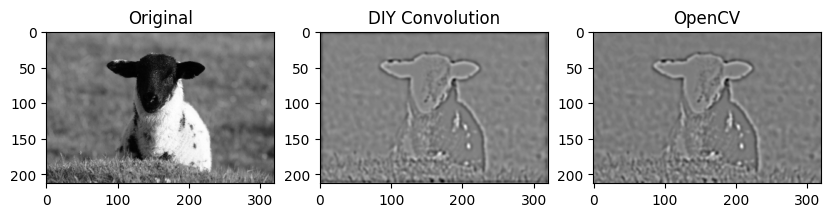

In [5]:
filtered = convolve(img/255, kernel)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img/255, cmap='gray')
axs[1].imshow(filtered, cmap='gray')
axs[2].imshow(cv2.filter2D(img/255, -1, kernel), cmap='gray')

axs[0].set_title('Original')
axs[1].set_title('DIY Convolution')
axs[2].set_title('OpenCV')

### Now, let's see what happens changing sigma scale.

I will test sigma from 1 to 3, with 0.1 step.
Kernel size will be 21 as usual. I found this to be a good tradeoff between accuracy and computation time.

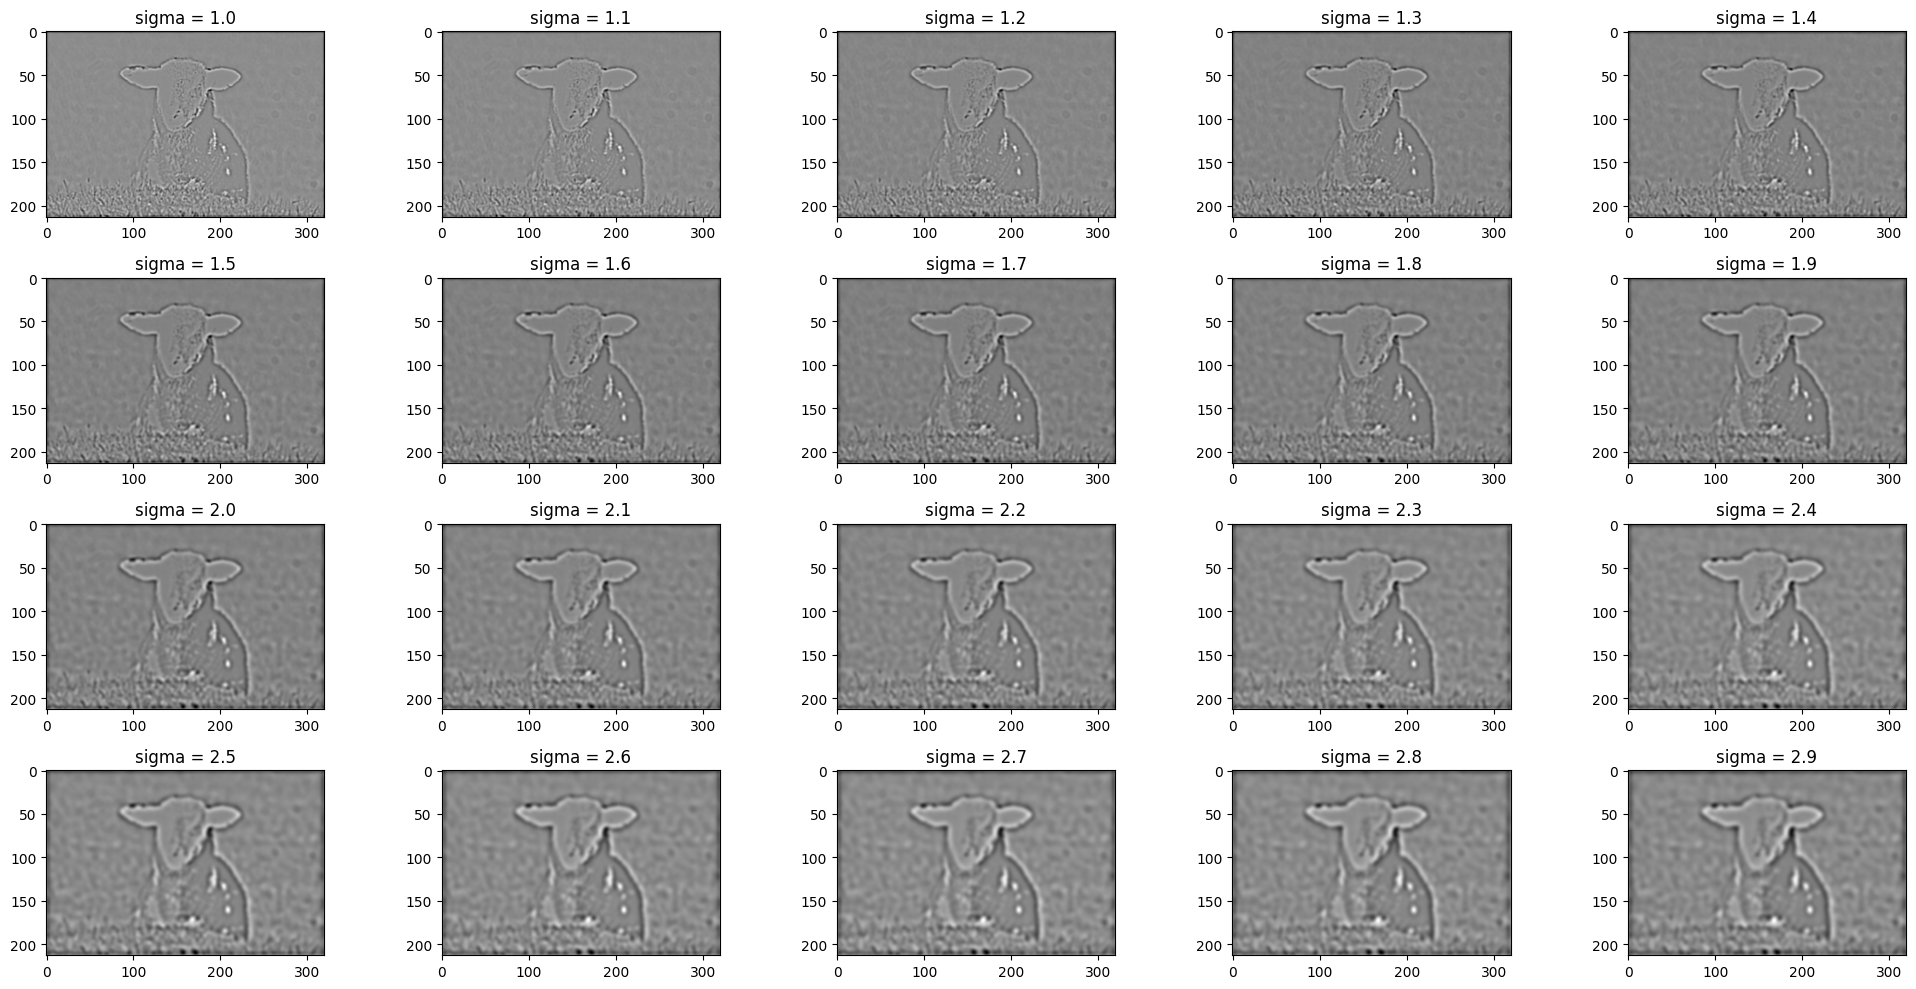

In [6]:
# try 10 values of sigma and plot it in range 1.5 to 2.5 with step 0.1
sigmas = np.arange(1, 3, 0.1)
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i, sigma in enumerate(sigmas):
    kernel = laplacian_of_gaussian(21, sigma)
    filtered = convolve(img/255, kernel)
    axs[i//5, i%5].imshow(filtered, cmap='gray')
    axs[i//5, i%5].set_title(f'sigma = {round(sigma,2)}')
fig.tight_layout()

### Results:
Sigma scaling seem working as expected. The more sigma increases, the more the image is blurred.

## Let's dig into the tricky part: blob detection

In order to detect blobs, we have to convolve the image with the LoG kernel at different scales. Since blobs are areas of gradient stability, we have to find the local maxima of the LoG response, across different scales. We also have to threshold the response, to avoid everything to be considered a blob. Moreover, we have to remove duplicates, since the same pixel may be considered a blob center in different iterations of the algorithm.

The algorithm is the following:
1. Generate a set of kernels, with different sigma values, within a user selected range (bounded by `sigma_start` and `sigma_end`). User may also want to change kernel dimension.
2. For each kernel, convolve the image with it. Now we have a 3D matrix, of shape `(image_height, image_width, len(kernels))`.
3. Generate also an array `blob_cords` to store the coordinates of the blobs found and the corresponding sigma value.
4. Now, the algorithm will iterate across this 3D matrix, pixel by pixel, considering a surrounding 2D window of size `stride`. Now, we find the maximum of this new 3D matrix of shape (stride, stride, len(kernels)). If this maximum is greater than the threshold, we consider the pixel as a blob center.
5. After this, we store blob center coordinates, and the corresponding sigma value, in `blob_cords`. The sigma value will be multiplied by $\sqrt2$ since LoGs have maximum response within a circle of radius $\sigma\sqrt2$.


In [22]:
def detect_blobs(img, threshold=1, sigma_start=1, sigma_end=4, sigma_step=1, kernel_size=11, stride=3, normalize=False):

    if normalize:
        img = img/np.max(img)

    scales = np.arange(sigma_start, sigma_end, sigma_step)
    kernels = [laplacian_of_gaussian(kernel_size, s) for s in scales]

    height, width = img.shape

    filtered = [convolve(img, kernel) for kernel in kernels]
    filtered = np.array([np.pad(i, (stride, stride), 'constant') for i in filtered])
    blob_cords = []
   
    for x in range(1, height, stride):
        for y in range(1, width, stride):
            region = filtered[:, x:x+stride, y:y+stride]
            candidate_max = np.max(region)
            level, h, w = np.unravel_index(np.argmax(region), region.shape)
            if candidate_max > threshold:
                blob_cords.append((1.414*(scales[level]), x+h-stride, y+w-stride))
                
    return set(blob_cords)

## Test the algorithm

Let's first test the algorithm on our sheep image. The following cell will show results for different threshold values.
Images have been normalized to [0,1] range. Kernel size and stride are 71 and 10 respectively. Sigma range is 2 to 20, with 1.0 stepsize.
This values were empirically found again as a good tradeoff between accuracy and computation time. In general, as sigma increases, we will need to increase kernel size, because of the accuracy of the approximation of the LoG. Increasing sigma and kernel size tipically improved blob's quality across different scales.

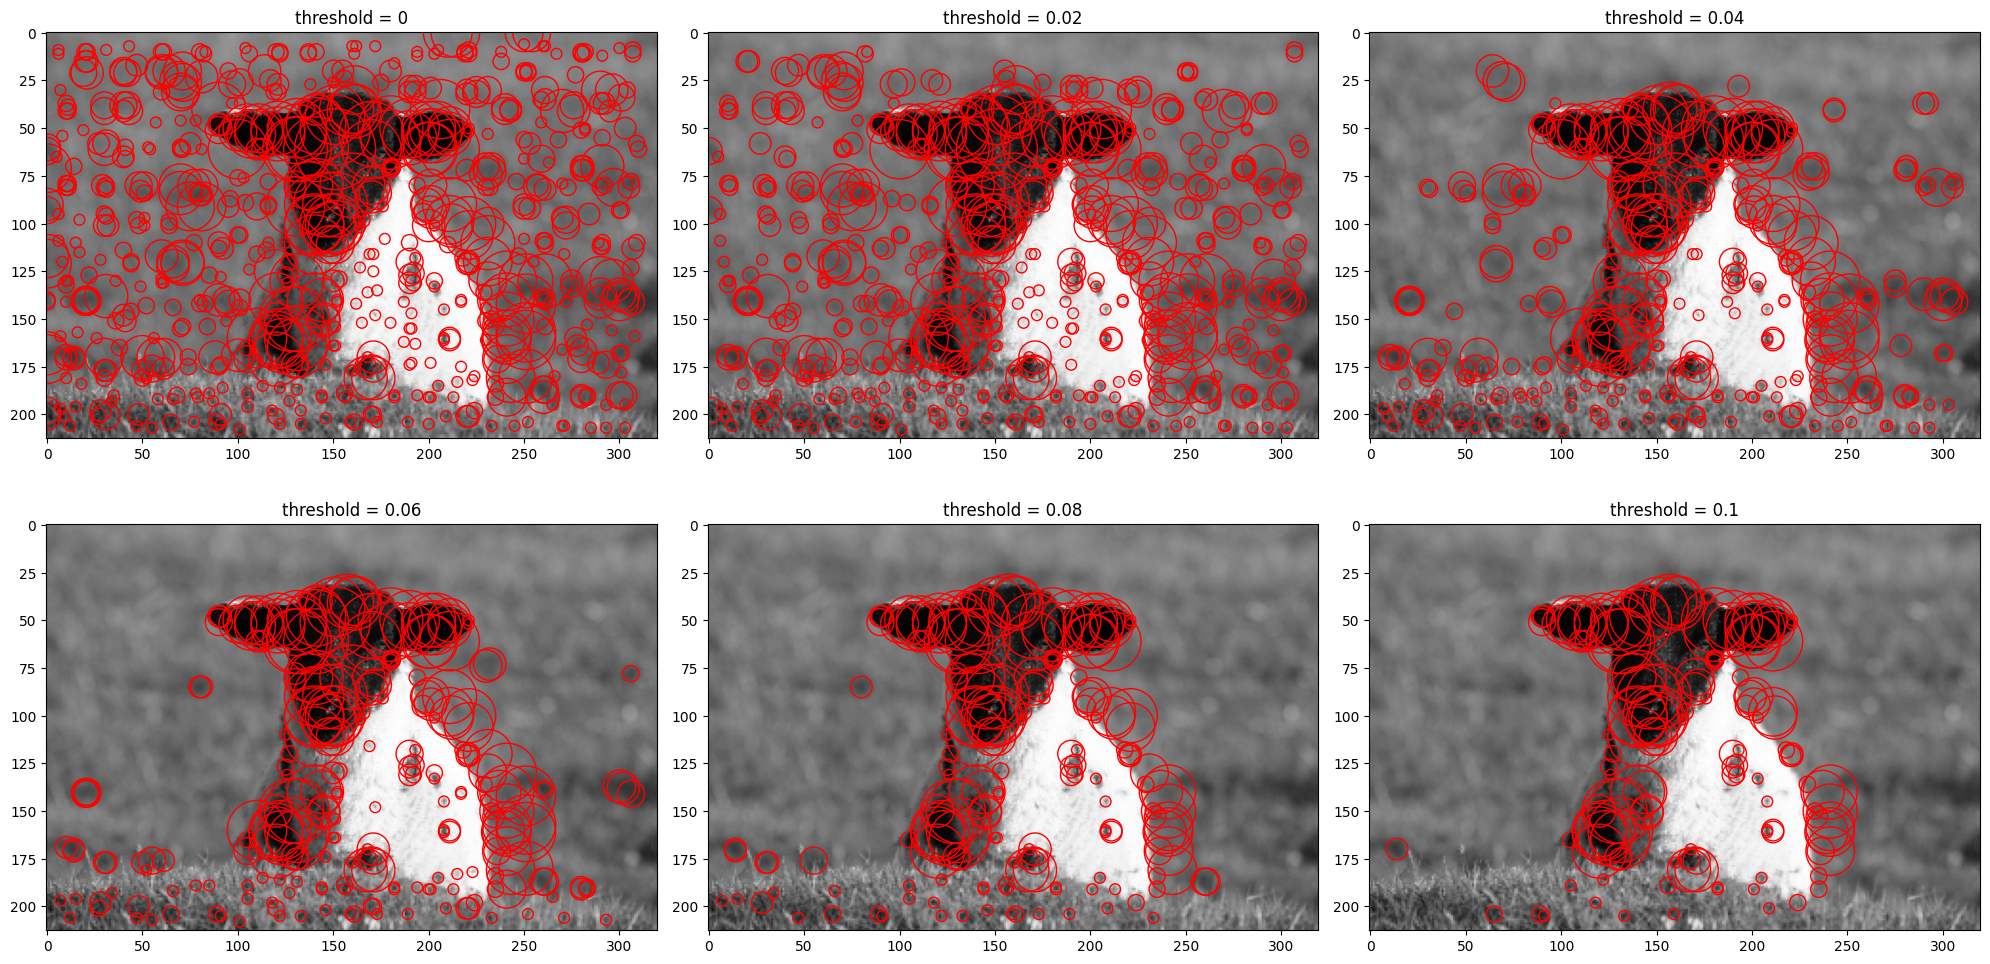

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# try different values of threshold
for i, threshold in enumerate([0, 0.02, 0.04, 0.06, 0.08, 0.1]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=2, 
        sigma_end=20, 
        sigma_step=1, 
        kernel_size=71, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))


fig.tight_layout()

### Trying on different subjects: humans

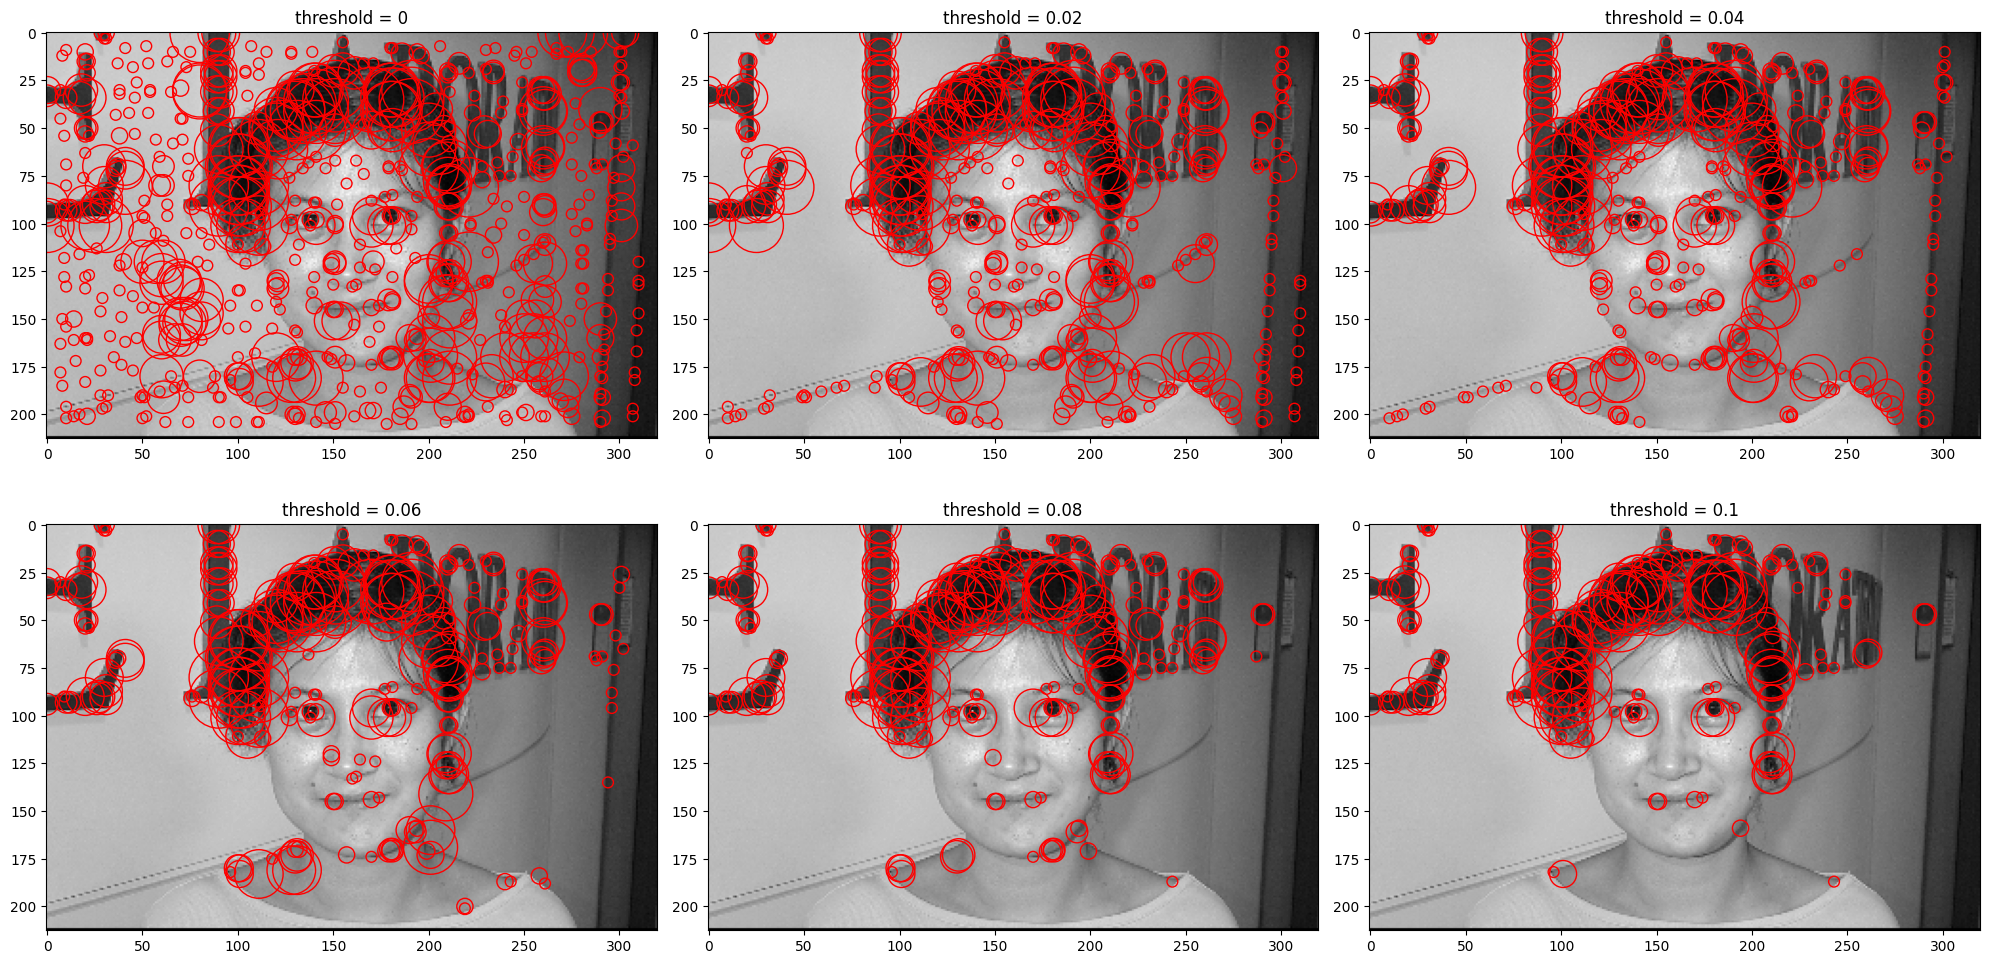

In [44]:
# test on human face image
img = cv2.imread('./images/6_30_s.bmp', cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, threshold in enumerate([0, 0.02, 0.04, 0.06, 0.08, 0.1]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=2, 
        sigma_end=20, 
        sigma_step=1, 
        kernel_size=71, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))


fig.tight_layout()


### Test on buildings

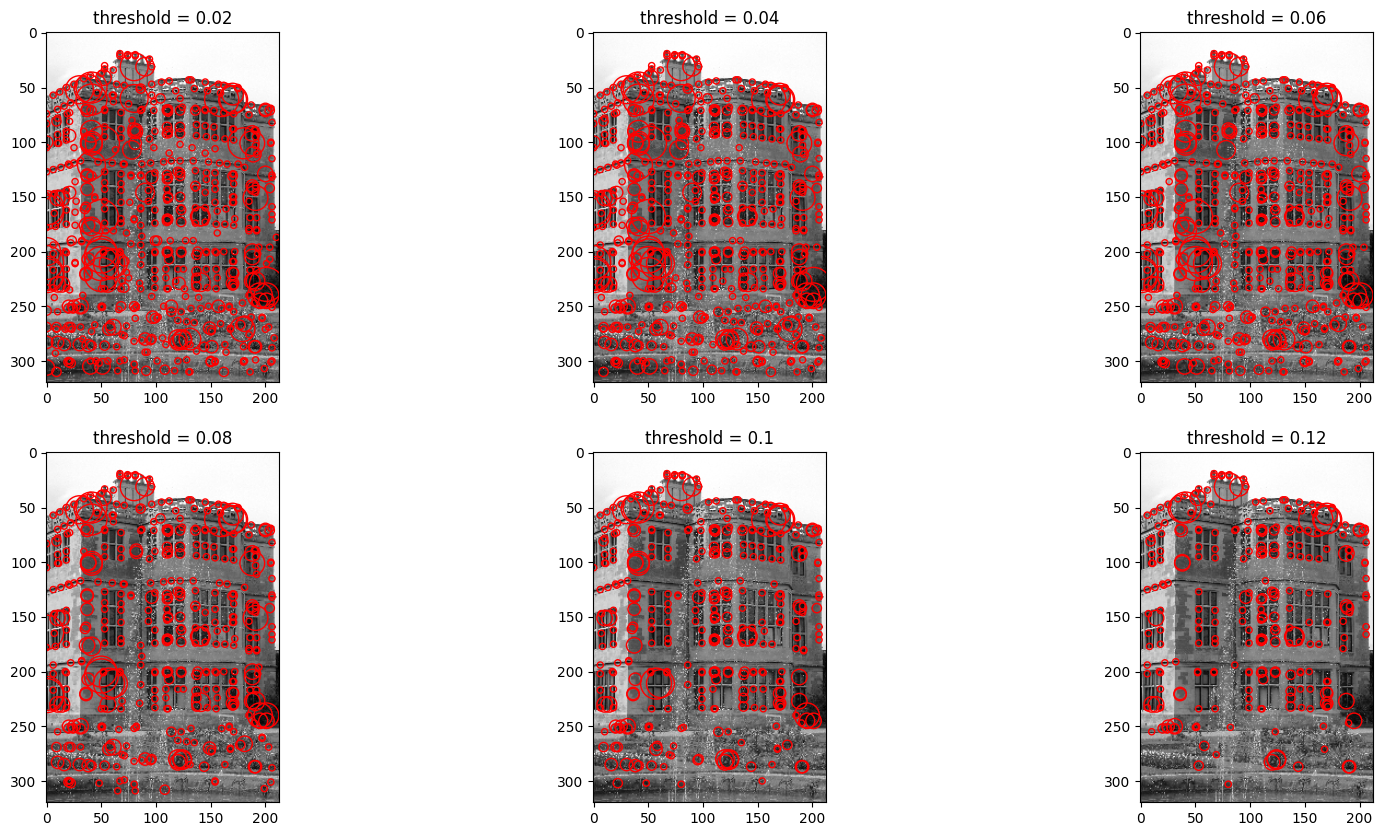

In [46]:
img  = cv2.imread('./images/3_2_s.bmp', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, threshold in enumerate([0.02, 0.04, 0.06, 0.08, 0.1, 0.12]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=2, 
        sigma_end=20, 
        sigma_step=1, 
        kernel_size=71, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))


### Test on cars

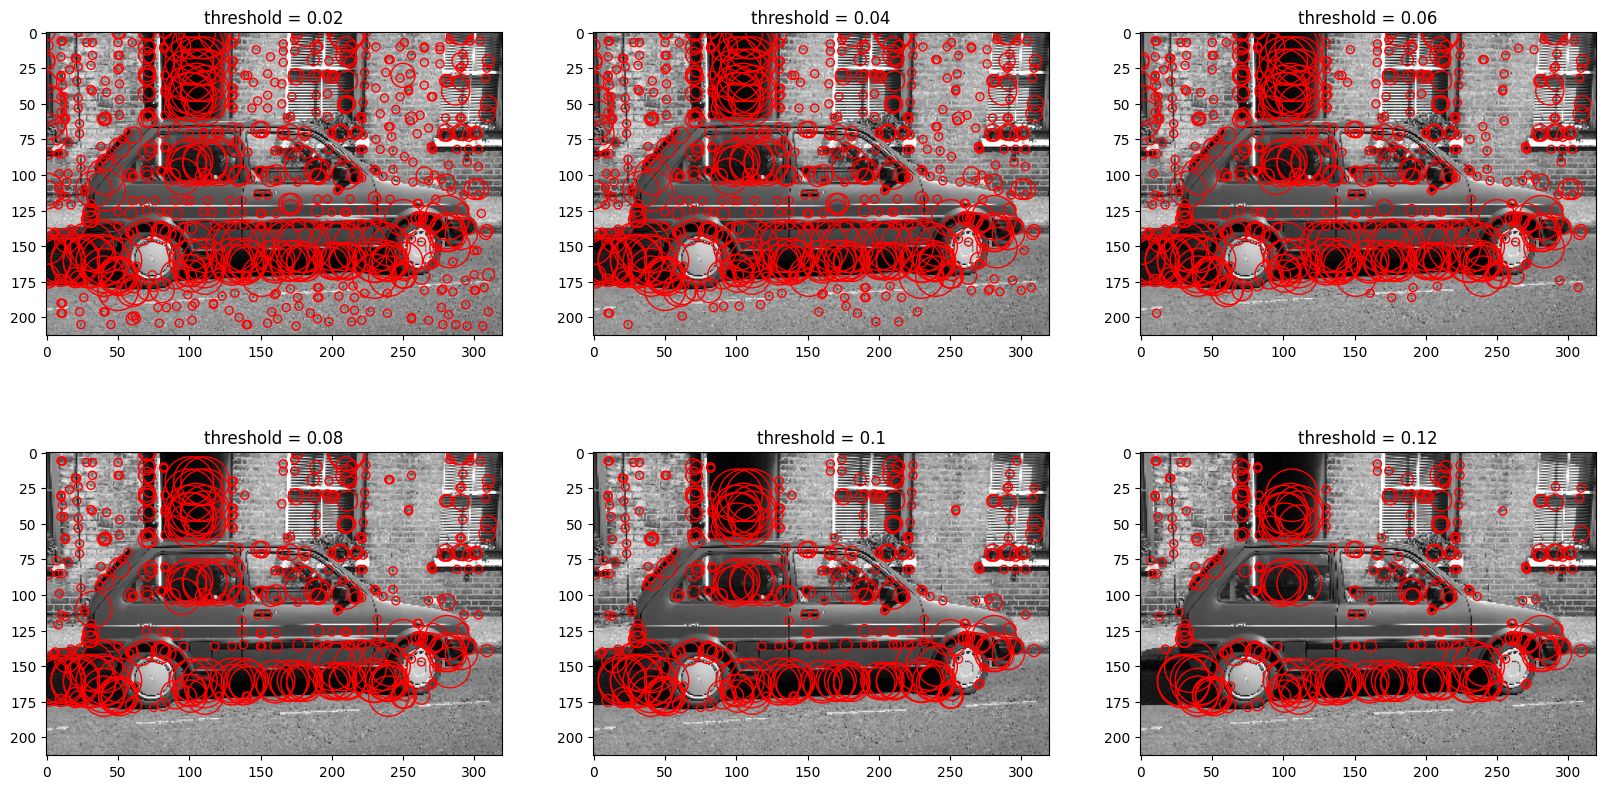

In [47]:
img = cv2.imread('./images/7_6_s.bmp', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, threshold in enumerate([0.02, 0.04, 0.06, 0.08, 0.1, 0.12]):
    blobs = detect_blobs(
        img, 
        threshold=threshold, 
        sigma_start=2, 
        sigma_end=20, 
        sigma_step=1, 
        kernel_size=71, 
        stride=10, 
        normalize=True
    )
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(f'threshold = {threshold}')
    for blob in blobs:
        axs[i//3, i%3].add_patch(plt.Circle((blob[2], blob[1]), blob[0], fill=False, color='r'))

## References
The proposed algotithm is based on the following papers and materials:

1. Course slides
2. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6408211
3. https://www.sciencedirect.com/science/article/abs/pii/S1051200419301460?casa_token=ICir1eATqakAAAAA:oYIkoxYUneQLjjmJ9fGDx4oCKuY77bED0cYuTZBH7ptyNbqSfhzMYFkRJh6m1aJPUGE3ziIi
4. https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94